# Multislice simulations (ED and CBED)

The multislice algorithm works by propagating the 2D lateral part of the wave function slice-by-slice forward along the optical axis (which in abTEM is by definition the positive `z` direction). A forward step through a slice of the potential consists of a transmission and a propagation. The `Wave` objects can be transmitted through a potential slice, which in the weak-phase approximation is just a phase shift. To complete one forward step, the transmitted wave is then propagated by a distance corresponding to the thickness of the slice using the Fresnel free-space approximation.

We import the potential from the previous tutorial and set up a plane wave with an energy of 300 keV.

In [1]:
from abtem.potentials import ArrayPotential
from abtem.waves import PlaneWave

potential = ArrayPotential.read('data/srtio3_110_potential.hdf5')

wave = PlaneWave(energy=300e3)

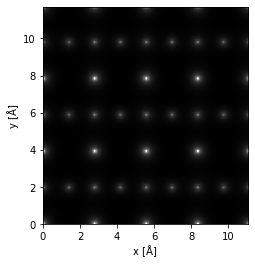

In [2]:
potential.show()

To propagate the wave function through the potential we use the `.multislice` method.

In [3]:
from abtem.potentials import Potential

pw_exit_wave = PlaneWave(energy=300e3).multislice(potential)

pw_exit_wave.write('data/srtio3_110_exit_wave.hdf5')

We show the intensity of the resulting exit wave.

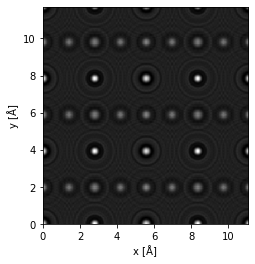

In [4]:
pw_exit_wave.show()

The electron diffraction pattern can be obtained using the `.diffraction_pattern` method.

In [5]:
pw_diffraction_pattern = pw_exit_wave.diffraction_pattern()

A diffraction pattern typically has a very large dynamic range in its intensity. Hence, we display it on a logarithmic scale. Note that this pattern is simulated without any decoherence or aberrations, and thus all diffraction orders are visible (please see Walkthrough 5 on the Contrast Transfer Function).

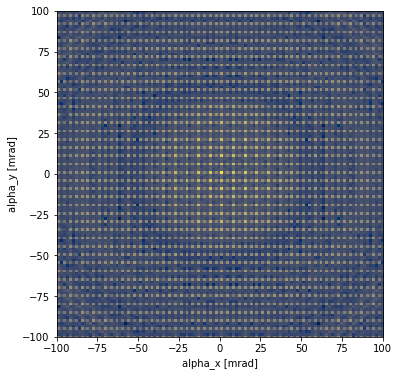

In [6]:
ax, im = pw_diffraction_pattern.show(log_scale=True, figsize=(6,6), cmap='cividis')

ax.set_xlim([-100,100])
ax.set_ylim([-100,100]);

<div class= "alert alert-info">

**Note:**

You may have noted that the grid of the wave function was not given above. Using the multislice function, the wave function just adopts the grid of the potential before starting the multislice propagation. On the other hand, the following will result in a runtime error because the sampling cannot be inferred from the information given.

```python
wave = PlaneWave(energy=300e3)
potential = Potential(atoms)
exit_wave = wave.multislice(potential)
```

The next bit of code will also result in an error because the sampling of the wave function and the potential is different.

```python
wave = PlaneWaves(sampling=.1, energy=300e3)
potential = Potential(atoms, sampling=.05)
exit_wave = wave.multislice(potential)
```
    
</div>

## Multislice simulation with probe

For a probe, we additionally define the probe convergence semiangle (in mrad) via `semiangle_cutoff`, with the parameter `rolloff` smoothing the cutoff, emulating a finite source size. Imaging modes utilizing an electron probe requires us to provide a positions for the probe (here a single location at 5 Å both in $x$ and $y$).

In [7]:
from abtem.waves import Probe

probe = Probe(energy=300e3, semiangle_cutoff=20, rolloff=.1)

We can position the probe close to an atom by reloading our SrTiO$_3$ model, and reading the `xy` position of one of the Sr atoms.

In [8]:
from ase.io import read

srtio3_110 = read('data/srtio3_110.cif')

pos = srtio3_110[1].position[:2]

We then simulate the exit wave via a multislice simulation of the probe placed at this position.

In [9]:
probe_exit_wave = probe.multislice(positions=pos, potential=potential)

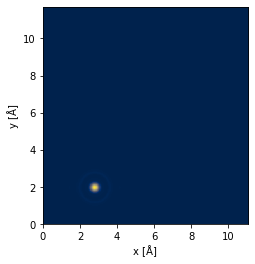

In [10]:
probe_exit_wave.show(cmap='cividis')

The convergent-beam electron diffraction (CBED) pattern can be calculated in the same manner as the ED pattern. We again display the result on a log scale. Note that to get more useful results, we should go back and increase our sampling of the potential.

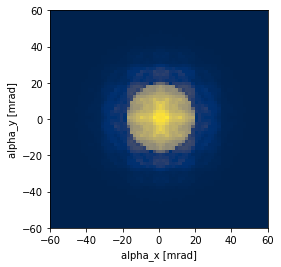

In [11]:
cbed_diffraction_pattern = probe_exit_wave.diffraction_pattern()

ax, im = cbed_diffraction_pattern.show(log_scale=False, cmap='cividis')
ax.set_xlim([-60,60])
ax.set_ylim([-60,60]);

## The multislice algorithm using low-level interface

If additional control is necessary, it is possible to run the multislice algorithm using a lower-level interface. We start by building a plane wave wavefunction. We ensure that the wave function matches the potential by using `.match` method of the wave function grid `wave.grid`.

In [12]:
wave = PlaneWave(energy=300e3)

wave.grid.match(potential)

wave = wave.build()

We then complete one step of the multislice algorithm by transmitting and then propagating the wave function. This requires importing the `FresnelPropagator` class and the `transmit` function. 

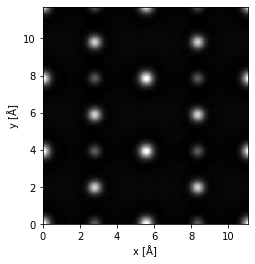

In [13]:
from abtem.waves import FresnelPropagator, transmit

potential_slice = potential[4]
propagator = FresnelPropagator()

wave = transmit(wave, potential_slice)
wave = propagator.propagate(wave, potential_slice.thickness)

wave.show()

The complete multislice algorithm simply repeats this for all slices sequentially, and hence it can be implemented as the following loop.

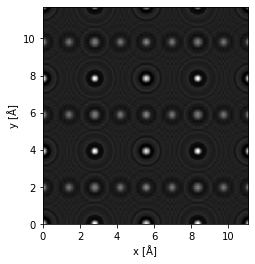

In [14]:
for potential_slice in potential:
    transmit(wave, potential_slice)
    propagator.propagate(wave, potential_slice.thickness)

wave.show();